# Latihan-5b_2layerAVO_gassmann

Latihan ini untuk menggabungkan gassmann dan avo interface model yang terdiri dari 2-3 block layers digunakan untuk menganalisis respon amplitudo terhadap interface antara top dan bottom layers
<br><br> _citation for this page: "Adi Widyantoro, 2021, Pertamina Seismic QI Course, Latihan-5b_2layerAVO_gassmann.ipynb, accessed MM DD, YYYY."_  
<br>
>(update terakhir tanggal 1 Juli 2021 oleh Adi Widyantoro)
<hr>

__Tahap-1__ 
<br> Program setup dan display sama seperti latihan sebelumnya. Gunakan hasil dari Latihan-2 data untuk latihan selanjutnya
<br> 

        special notes: brugeslibrary adalah kumpulan pre-defined functions oleh Agile Geoscience bruges:
        https://github.com/agile-geoscience/bruges
        
        the library's credits go to bruges contributors: Evan Bianco, Ben Bougher, Matt Hall, Alessandro Amato del Monte, 
        Wes Hamlyn, Sean Ross-Ross

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math
from scipy.signal import hilbert
from f05avostyleplot import basicgassmann,shuey,AR3term

__Tahap-2__ 
<br> Mendapatkan nilai rata-rata untuk masing-masing interval, misalnya data dari Latihan-2 sebelumnya adalah sbb:

In [2]:
# Lapisan pertama
vp1=4050; vs1=2840; rho1=2.67
# Lapisan kedua
vp2=3500; vs2=2050; rho2=2.35
# parameters
angmin, angmax = 0, 40 
n_samples, gain = 400, 5
interface=int(n_samples/2)
ang = np.arange(angmin,angmax+1,1)
z = np.arange(n_samples)

__Tahap-3__ 
<br>Menghitung reflektivitas dengan pendekatan AVO sederhana, e.g.: 2-term Shuey atau Aki Richard. Gunakan salahsatu contoh input di atas dan diskusikan dalam kelas. Gunakan simple zerophase Ricker wavelet seperti pada Latihan-4. Diskusikan di dalam kelas untuk rotasi wavelet

In [3]:
"""
default wavelet yang digunakan adalah Ricker central frequency 25Hz, 200samples
eksplorasi pilihan rotasi wavelet dengan mengubah ph=0 menjadi rotasi yang diinginkan misalnya ph=-90deg
"""
f, l, dt, ph = 25, 200, 0.5, 0
t = np.arange(-l/2, l/2, dt)/1000
zerophase = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
h = hilbert (zerophase)
theta = ph*np.pi/180
wavelet = np.cos(theta)*h.real-np.sin(theta)*h.imag
print(len(t), len(wavelet))

400 400


In [4]:
avoA = shuey(vp1,vs1,rho1,vp2,vs2,rho2,ang)
rcA, synA = (np.zeros((n_samples,ang.size)) for _ in range(2))
rcA[interface,:]=avoA
for i in range(ang.size):
    synA[:,i] = np.convolve(rcA[:,i],wavelet,mode='same')

In [5]:
rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine
rho_o=0.78;   k_o=0.94              # fluid properties, oil
rho_g=0.25;   k_g=0.06              # fluid properties, gas

In [6]:
phi=0.10
sg=0.8
k_fl=1/((1-sg)/k_b + sg/k_g)
rho_fl = sg*rho_g+(1-sg)*rho_b
vp2B,vs2B,rho2B,_,_= basicgassmann(vp1, vs1, rho1, rho_b, k_b, rho_fl, k_fl, k_qz, phi)
print(round(vp2B), round(vs2B),rho2B)

3321 2876 2.6028


In [7]:
ipA,ipB,vpvsA,vpvsB = (np.zeros(n_samples) for _ in range(4))
ipA[:interface] = vp1*rho1; ipA[interface:] = vp2*rho2
ipB[:interface] = vp1*rho1; ipB[interface:] = vp2B*rho2B
vpvsA[:interface] = vp1/vs1; vpvsA[interface:] = vp2/vs2
vpvsB[:interface] = vp1/vs1; vpvsB[interface:] = vp2B/vs2B

In [8]:
avoB = shuey(vp1,vs1,rho1,vp2B,vs2B,rho2B,ang)
rcB, synB = (np.zeros((n_samples,ang.size)) for _ in range(2))
rcB[interface,:]=avoB
for i in range(ang.size):
    synB[:,i] = np.convolve(rcB[:,i],wavelet,mode='same')    

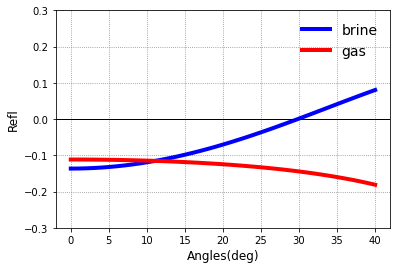

In [9]:
plt.plot(avoA,'b',label="brine", lw=4);plt.plot(avoB,'r', label="gas", lw=4);plt.grid(color='gray', linestyle=":")
plt.legend(loc="upper right", frameon=False, fontsize=14); plt.ylim([-0.3,0.3]); 
plt.xlabel('Angles(deg)',fontsize=12); plt.ylabel('Refl',fontsize=12) 
plt.axhline(0, linewidth=1, color='k'); plt.show()

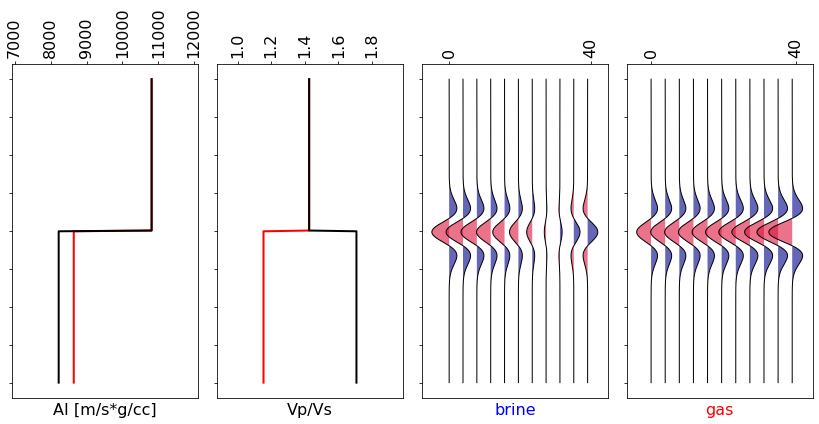

In [10]:
#-------------The ..plot----------------------
f=plt.subplots(figsize=(20, 6))
ax0 = plt.subplot2grid((1,7), (0,0), colspan=1)
ax1 = plt.subplot2grid((1,7), (0,1), colspan=1)
ax2 = plt.subplot2grid((1,7), (0,2), colspan=1)
ax3 = plt.subplot2grid((1,7), (0,3), colspan=1)
ax0.plot(ipB, z, 'r', lw=2, zorder=1); ax0.plot(ipA, z, 'k', lw=2, zorder=5)
ax0.set_xlabel('AI [m/s*g/cc]', fontsize=16); ax0.margins(x=0.5)
ax1.plot(vpvsB, z,'r', lw=2, zorder=1); ax1.plot(vpvsA, z, 'k', lw=2, zorder=5)
ax1.set_xlabel('Vp/Vs',fontsize=16); ax1.margins(x=0.5)
for i in range(0,int(ang.size),4):
    traceA=gain*synA[:,i]/np.max(np.abs(synA))
    ax2.plot(i+traceA,z,'k', lw=1)
    ax2.fill_betweenx(z,traceA+i,i,where=traceA+i>i,facecolor='darkblue', alpha=0.6)
    ax2.fill_betweenx(z,traceA+i,i,where=traceA+i<i,facecolor='crimson', alpha=0.6)
    ax2.set_xticks([0,ang.size])
    ax2.set_xticklabels(['0','40'])
ax2.margins(x=0.06); ax2.set_xlabel('brine', fontsize=16,color='blue')
for i in range(0,int(ang.size),4):
    traceB=gain*synB[:,i] / np.max(np.abs(synA))
    ax3.plot(i+traceB,z,'k',lw=1)
    ax3.fill_betweenx(z,traceB+i,i,where=traceB+i>i,facecolor='darkblue', alpha=0.6)
    ax3.fill_betweenx(z,traceB+i,i,where=traceB+i<i,facecolor='crimson', alpha=0.6)
    ax3.set_xticks([0,ang.size])
    ax3.set_xticklabels(['0','40'])
ax3.margins(x=0.06); ax3.set_xlabel('gas', fontsize=16, color='r')
for aa in [ax0, ax1, ax2, ax3]:
    aa.invert_yaxis()
    aa.xaxis.tick_top()
    plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=16)
    aa.set_yticklabels([])
plt.tight_layout()    

<h1><center>-Akhir Program Latihan-5b-<center></h1>